In [1]:
'''Flickr 30k Grounding with PyTorch.'''
from FlickrDataset2 import FlickrDataset2
from tensorboardX import SummaryWriter
from __future__ import print_function
import matplotlib.patches as patches
from torch.autograd import Variable
from torchvision import transforms
from skimage.morphology import *
import matplotlib.pyplot as plt
from Model3 import Model3
from net_util import *
from parser import *
import statistics
import math
import cv2
%matplotlib inline  
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
def retrieve_bboxes(att_map, bboxes):
    # compute the mean value of attention map
    mean = np.mean(att_map)
    # transform to 0-255 scale image
    test = (att_map * 255).astype('uint8')
    # threshold set to 3 times of mean value
    ret,thresh = cv2.threshold(test,round(mean*3*255), 255, 0)
    # contour detection
    im2, cts, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours = []
    # storing all countors and exlude area less then 4 pixels
    for i in range(0,len(cts)): 
        x, y, w, h = cv2.boundingRect(cts[i]) 
        # expanding the detected region to 120% for sub-window search
        x -= 0.4*w
        y -= 0.4*h
        w += .8*w
        h += .8*h
        if w>2 and h>2:
            contours.append(np.clip([round(x), round(y), round(x+w), round(y+h)], 0, att_map.shape[0]))
    # selecting all bboxes inside the contours
    # instead of picking bboxes out, we store the desired bboxes index
    target = np.zeros(500,)
    feat_bboxes = []
    count = 0
    num_boxes = 0
    # selected boxes index
    print(contours)
    target = np.zeros(bboxes.shape[0],)
    for box in bboxes:
#         resized_box = box/(256/att_map.shape[0])
        x_min, y_min, x_max, y_max = box.cpu().data.numpy()
        for contour in contours:
            contour2 = contour * (1024/att_map.shape[0])
            # check if box is inside the contour
#             print(x_min, y_min, w, h)
            if x_min >= contour2[0] and y_min >= contour2[1] and x_max <= contour2[2] and y_max <= contour2[3]:
                target[count] = 1
                num_boxes += 1
                break
        count += 1
    return target, num_boxes

def margin_loss(visual_feat, text_feat, label, margin=0.1):
    # Margin loss compute the loss as follows:
    # label: 0 or 1; v, t: target features; margin: minimum range between negative features
    # Loss = y(v-t)^2 + (1-y)(margin - ||v-t||)
    diff = visual_feat - text_feat
    dist = (torch.mul(diff, diff).sum(1) / visual_feat.shape[1]).sqrt()
    zero = Variable(torch.from_numpy(np.zeros(1))).cuda().float()
    loss = label*dist + (1 - label)*torch.max(zero, margin - dist)
    return loss.sum(0)/loss.shape[0]

def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
 
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
 
	# initialize the list of picked indexes	
	pick = []
 
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
 
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
 
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
 
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
 
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
 
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
 
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

In [67]:
# Load Pretrained Model.
class opts():
    backbone_model = './models/mrcnn.pth'
    class_num = 81
    batch_size = 64
    resume = './checkpoint/Model2_coco_P3-P4-P5.pth'

    
opts = opts()
model = Model3(opts)
# Load Back bone Module
state_dict = torch.load(opts.resume)['state_dict']
new_params = model.state_dict()
new_params.update(state_dict)
model.load_state_dict(new_params)
model.cuda()
model.eval()
print('Model loaded')

==> Building backbone model...
Model loaded


In [12]:
# Load dataset and images
print("Preparing Flickr data set...")
size = (1024, 1024)
feat_size = (64, 64)
transform = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])
data_set = FlickrDataset2('/media/drive1/Data/flickr30k/flickr30k_images/', feat_size, transform)
data_loader = torch.utils.data.DataLoader(data_set, batch_size=1,shuffle=False)

Preparing Flickr data set...
Loading dictionary...
Dictionary loaded.


/media/drive1/flickr_unsupervised_grounding_cocobased/FlickrDataset2.py:76: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ran not in attributes:


1
A girl
[array([49, 49, 58, 62]), array([ 9, 38, 35, 64]), array([25, 23, 38, 33]), array([ 0,  9, 44, 58]), array([25,  0, 64, 64]), array([34,  5, 38, 13]), array([ 7,  3, 30, 22])]
[/EN#231549/people A girl] playing with [/EN#231550/other toys] .


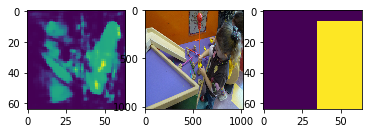

In [69]:
# attention map
# 7341: multi-person interesting image
(img, category, (one_hot, label), textual_emb, phrase, mask, line, filename, size, all_one_hot, att_emb, att_label) = data_set[1940]

model.visual_net.config.IMAGES_PER_GPU = 1

images = Variable(img.view(1, 3, 1024, 1024)).cuda()
# One-hot input
one_hot = Variable(torch.from_numpy(one_hot.reshape(1,-1))).cuda().float()
# one_hot = np.zeros((1, 81))
# one_hot[0] = 1
# one_hot = Variable(torch.from_numpy(one_hot)).cuda().float()
att_emb = torch.from_numpy(att_emb)
att_emb = Variable(att_emb.view(att_emb.shape[0],att_emb.shape[1]).float()).cuda()
model.visual_net.config.IMAGES_PER_GPU = 1
v_feat, t_feat, att_map, rpn_rois, P3 = model(images, one_hot, att_emb)
print(label)
plt.subplot(131)
plt.imshow(att_map[0,0].data)
plt.subplot(132)
plt.imshow(img.permute(1,2,0).float().cpu())
plt.subplot(133)
plt.imshow(mask)
print(phrase)
att = att_map[0,0].data.cpu().numpy()

# retriev all possible sub-boxes
target, num_boxes = retrieve_bboxes(att>0.3, rpn_rois[0])
print(line)

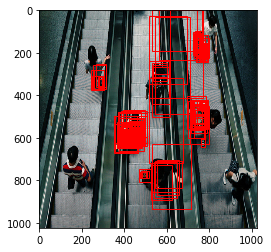

In [35]:
fig,ax = plt.subplots(1)
count = 0
target_box = []
for box in rpn_rois[0]:
    if target[count] == 1.:
        x1, y1, x2, y2 = box.cpu().data.numpy()
#         if (y2-y1)*(x2-x1) > 104857:
        target_box.append(box.cpu().data.numpy())
        rect = patches.Rectangle((round(x1), round(y1)), round(x2-x1), round(y2-y1), linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    count += 1
# rect = patches.Rectangle((round(mx1), round(my1)), round(mx2-mx1), round(my2-my1), linewidth=1,edgecolor='r',facecolor='none')
# ax.add_patch(rect)
ax.imshow(img.permute(1,2,0).float().cpu())

In [487]:
# boxes = non_max_suppression_fast(np.asarray(target_box), 0.9)
# fig,ax = plt.subplots(1)
# count = 0
# target_box2= []
# for box in boxes:
#     if target[count] == 1.:
#         x1, y1, x2, y2 = box
# #         if (y2-y1)*(x2-x1) > 14857:
#         target_box2.append(box)
#         rect = patches.Rectangle((round(x1), round(y1)), round(x2-x1), round(y2-y1), linewidth=1,edgecolor='r',facecolor='none')
#         ax.add_patch(rect)
#     count += 1
# # rect = patches.Rectangle((round(mx1), round(my1)), round(mx2-mx1), round(my2-my1), linewidth=1,edgecolor='r',facecolor='none')
# # ax.add_patch(rect)
# ax.imshow(img.permute(1,2,0).float().cpu())

In [36]:
line

'[/EN#196565/people People] riding [/EN#196566/scene escalators] .'

In [37]:
# Attribute embedding net scoring

# Generating possible testing masks
size = (64, 64)
count=0
min_score = 1
selected_box = np.zeros(size)
for box in target_box:
    p_mask = np.zeros(size)
#     x1, y1, x2, y2 = box.cpu().data.numpy()/(1024/128)
    x1, y1, x2, y2 = box/(1024/128)
    for x in range(p_mask.shape[0]):
        for y in range(p_mask.shape[1]):
            if x1<x<x2 and y1<y<y2:
                p_mask[y, x] = 1
    vp_mask = Variable(torch.from_numpy(p_mask)).float().cuda()
    v_feat, t_feat = model.ae_net(P3, vp_mask, att_emb)
    index = 0
#     for item in att_label:
#         if item == 1.:
#             diff = v_feat[index] - t_feat[index]
#             dist = (torch.mul(diff, diff).sum(0))/1024
#             loss += dist
#         index += 1
    loss = margin_loss(v_feat,5 t_feat, att_label)
    loss = loss.sum(0)/loss.shape[0]
    if loss < min_score:
        min_score = loss
        selected_box = p_mask
    print(count)
    count += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184


1
People
[array([51, 50, 56, 58]), array([28, 50, 47, 60]), array([16, 37, 33, 55]), array([ 2, 25, 10, 51]), array([58, 26, 62, 34]), array([54,  6, 63, 32]), array([32,  0, 50, 62]), array([15,  1, 32, 42]), array([ 3,  2, 12, 33])]
[/EN#196565/people People] riding [/EN#196566/scene escalators] .


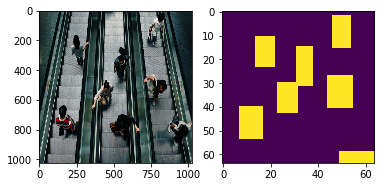

In [40]:
model.visual_net.config.IMAGES_PER_GPU = 1
v_feat, t_feat, att_map, rpn_rois, P3 = model(images, one_hot, att_emb)
print(label)
plt.subplot(121)
plt.imshow(img.permute(1,2,0).float().cpu())
plt.subplot(122)
plt.imshow(selected_box+mask)

print(phrase)
att = att_map[0,0].data.cpu().numpy()

# retriev all possible sub-boxes
target, num_boxes = retrieve_bboxes(att>0.3, rpn_rois[0])
print(line)

10


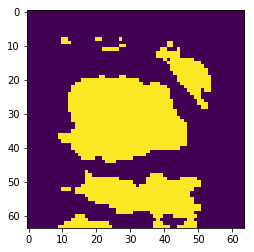

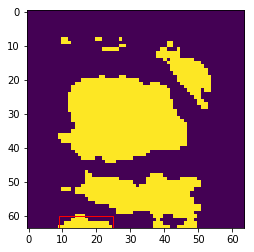

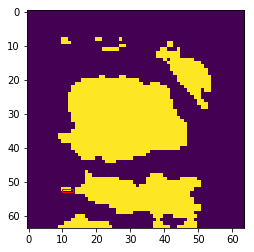

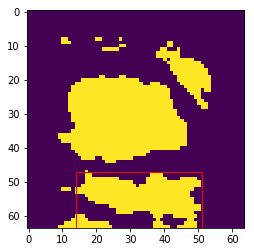

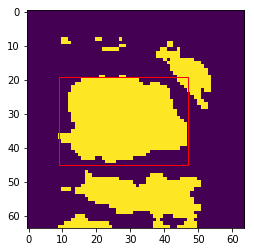

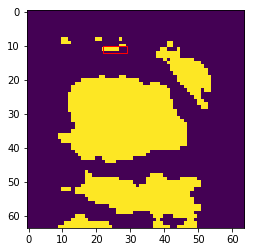

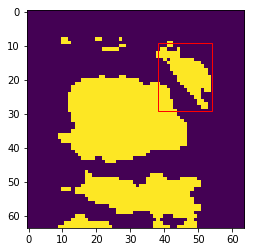

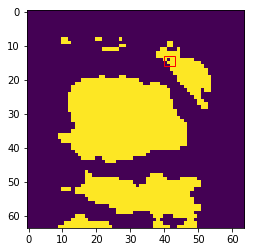

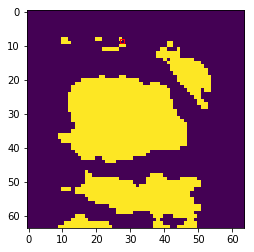

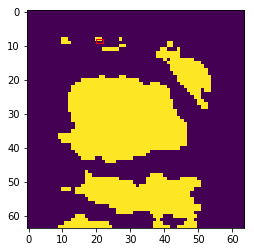

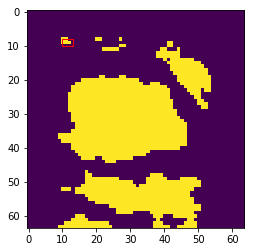

In [29]:
att = att>0.3
mean = np.mean(att)
fig1,ax1 = plt.subplots(1)
test = (att * 255).astype('uint8')
ax1.imshow(test)
ret,thresh = cv2.threshold(test,round(mean*3*255), 255, 0)
im2, cts, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
print(len(cts)) 

for i in range(0,len(cts)): 
    x, y, w, h = cv2.boundingRect(cts[i])  
#     if w < 2 or h <2:
#         break
    fig,ax = plt.subplots(1)
    ax.imshow(test)
    rect = patches.Rectangle((x, y),w, h,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)


7


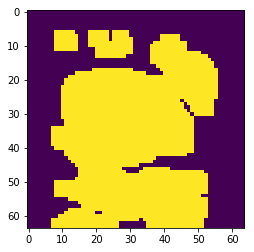

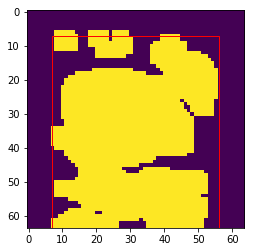

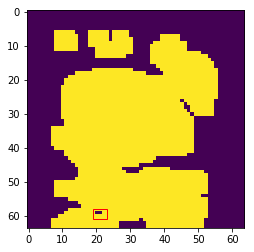

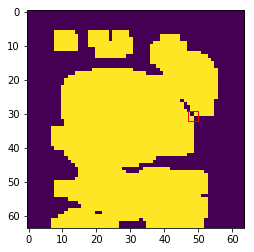

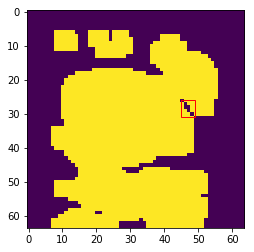

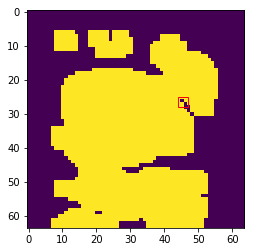

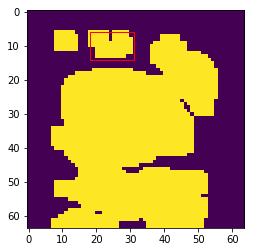

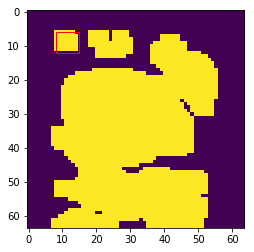

In [33]:
kernel = np.ones((5, 5),np.uint8)
test2 = cv2.dilate(test,kernel,iterations = 1)
plt.imshow(test2)
kernel = np.ones((5, 5),np.uint8)
opening = cv2.morphologyEx(test2, cv2.MORPH_OPEN, kernel)
ret,thresh = cv2.threshold(opening,round(mean*3*255), 255, 0)
im2, cts, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
print(len(cts)) 

for i in range(0,len(cts)): 
    x, y, w, h = cv2.boundingRect(cts[i])  
#     if w < 2 or h <2:
#         break
    fig,ax = plt.subplots(1)
    ax.imshow(opening)
    rect = patches.Rectangle((x, y),w, h,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)


In [ ]:
from PIL import Image
image = Image.open('test2.jpg')
img = image.convert('RGB')
image = transform(img)
image = image.view(1, 3, 512, 512 )
image = Variable(image).cuda().float()
one_hot = np.zeros((1, 81))
one_hot[0][1]  =  1
label = 2
one_hot = Variable(torch.from_numpy(one_hot)).cuda().float()
category_p3, att_map3, category_p4, att_map4, category_p5, att_map5, rpn_rois= model(image, one_hot, label)
plt.subplot(141)
plt.imshow(att_map3[0,0].data)
plt.subplot(142)
plt.imshow(att_map4[0,0].data)  
plt.subplot(143)
plt.imshow(att_map5[0,0].data)
plt.subplot(144)
plt.imshow(image[0].permute(1,2,0).data.float().cpu())


In [475]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import os
import cv2
import torch
import numpy as np
import torch.nn as nn
from config import Config
from mask_rcnn import MaskRCNN
import torch.nn.functional as F
from collections import OrderedDict
from CompactBilinearPooling import CompactBilinearPooling


class AENet(nn.Module):

    def __init__(self):
        super(AENet, self).__init__()
        self.avgpool= nn.AvgPool2d(128)
        self.visual_fc = nn.Linear(256, 1024)
        self.text_fc = nn.Linear(300, 1024)
        self.conv = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=1, bias=True)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, P3, entity_map, embedding):
        text_feat = self.sigmoid(self.text_fc(embedding))
        visual_feat = self.avgpool(torch.mul(P3, entity_map))
        visual_feat = visual_feat.view(visual_feat.shape[0], visual_feat.shape[1])
        visual_feat = self.sigmoid(self.visual_fc(visual_feat))
        
        return text_feat, visual_feat


In [72]:
a = torch.randn(6, 256, 128, 128)

In [76]:
b = torch.randn(6, 256, 128, 128)

In [77]:
torch.cat([a, b], 1)


( 0 , 0 ,.,.) = 
  5.8117e-01  9.4535e-01  2.8971e-01  ...  -1.2851e+00 -5.6492e-01 -3.3863e-01
 -5.3616e-01  1.7347e+00 -1.2707e+00  ...  -4.2641e-01  7.6335e-01 -3.3825e-02
 -3.1338e-01  1.5516e-01  9.4888e-01  ...  -1.0249e-01 -2.1855e-01 -2.4964e-01
                 ...                   ⋱                   ...                
 -5.3083e-01 -5.3193e-01  1.9291e-01  ...   8.9016e-01 -7.0673e-01  5.9041e-01
  2.8743e-01  1.2301e-01 -4.0466e-01  ...  -1.1883e+00  1.1216e+00  1.6288e-01
  5.7561e-01 -3.7161e-02 -3.5753e-01  ...  -1.3980e+00  3.7205e-01 -7.6071e-01

( 0 , 1 ,.,.) = 
 -1.2806e+00 -2.5471e+00  5.5345e-01  ...  -1.3753e+00 -7.4273e-01 -8.0289e-01
  5.8395e-01  9.0740e-01 -1.3364e+00  ...  -4.0183e-01 -5.5441e-02 -2.1793e+00
 -7.3641e-01  8.2565e-01  8.4203e-01  ...   2.4292e+00  1.2190e+00  4.2728e-01
                 ...                   ⋱                   ...                
  1.5751e+00 -1.0514e+00 -3.5338e-01  ...  -9.0851e-01 -2.3854e-01  1.5880e+00
  7.5839e-01  1.

In [78]:
a


( 0 , 0 ,.,.) = 
  5.8117e-01  9.4535e-01  2.8971e-01  ...  -1.2851e+00 -5.6492e-01 -3.3863e-01
 -5.3616e-01  1.7347e+00 -1.2707e+00  ...  -4.2641e-01  7.6335e-01 -3.3825e-02
 -3.1338e-01  1.5516e-01  9.4888e-01  ...  -1.0249e-01 -2.1855e-01 -2.4964e-01
                 ...                   ⋱                   ...                
 -5.3083e-01 -5.3193e-01  1.9291e-01  ...   8.9016e-01 -7.0673e-01  5.9041e-01
  2.8743e-01  1.2301e-01 -4.0466e-01  ...  -1.1883e+00  1.1216e+00  1.6288e-01
  5.7561e-01 -3.7161e-02 -3.5753e-01  ...  -1.3980e+00  3.7205e-01 -7.6071e-01

( 0 , 1 ,.,.) = 
 -1.2806e+00 -2.5471e+00  5.5345e-01  ...  -1.3753e+00 -7.4273e-01 -8.0289e-01
  5.8395e-01  9.0740e-01 -1.3364e+00  ...  -4.0183e-01 -5.5441e-02 -2.1793e+00
 -7.3641e-01  8.2565e-01  8.4203e-01  ...   2.4292e+00  1.2190e+00  4.2728e-01
                 ...                   ⋱                   ...                
  1.5751e+00 -1.0514e+00 -3.5338e-01  ...  -9.0851e-01 -2.3854e-01  1.5880e+00
  7.5839e-01  1.